In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#@title Read data
import os
import pandas as pd
import networkx as nx
import matplotlib as mpl
import numpy as np
import random

PRJ_DIR = os.path.join('/','content','drive','MyDrive','Colab Notebooks','eliorc_node2vec')
DATA_DIR = os.path.join(PRJ_DIR,'Facebook-Social-Network-Analysis-master')

# Read data
fb = pd.read_csv(os.path.join(DATA_DIR,'facebook_combined.txt'), delim_whitespace=True, names=['Source', 'Destination'])
fb.head()

In [2]:
#contents of one such file, namely '0.featnames'
with open(os.path.join(DATA_DIR,'facebook','0.featnames'), 'r') as f:
        feature_names = f.readlines()
        
feature_names_df = pd.read_csv(os.path.join(DATA_DIR,'facebook','0.featnames'), names=['Feature Names'])
# format of the values in the file : 
# 'feature number' + ' ' + 'feature name' + ';' + 'feature type'
# feature type always starts with 'anonymized feature' 
feature_names_df

,Feature Names
0,0 birthday;anonymized feature 0
1,1 birthday;anonymized feature 1
2,2 birthday;anonymized feature 2
3,3 birthday;anonymized feature 3
4,4 birthday;anonymized feature 4
...,...
219,219 work;start_date;anonymized feature 170
220,220 work;start_date;anonymized feature 171
221,221 work;start_date;anonymized feature 203
222,222 work;start_date;anonymized feature 204


In [3]:
# printing list of unique features in the '0.featnames'
unique_features = []

for i in range(len(feature_names)):
  feature_names[i] = feature_names[i].split(' ', 1)[1]
  feature_names[i] = feature_names[i].rsplit(';' , 1)[0]
  unique_features.append(feature_names[i])

list(set(unique_features))

['last_name',
 'education;concentration;id',
 'location;id',
 'work;end_date',
 'hometown;id',
 'gender',
 'work;location;id',
 'education;classes;id',
 'work;employer;id',
 'work;start_date',
 'work;with;id',
 'education;year;id',
 'education;degree;id',
 'birthday',
 'education;with;id',
 'first_name',
 'locale',
 'education;type',
 'education;school;id',
 'work;position;id',
 'languages;id']

In [4]:
#@title Creating a nested dictionary of all the nodes along with its attributes
def ExtractFeatureNames(path):
    with open(path, 'r') as f:
        feature_names = f.readlines()

    for i in range(len(feature_names)):
        feature_names[i] = feature_names[i].split(' ', 1)[1]
        feature_names[i] = feature_names[i].rsplit('\n' , 1)[0]
        feature_names[i] = feature_names[i].rsplit(';' , 1)
        feature_names[i][1] = feature_names[i][1].rsplit(' ' , 1)[1]
        
    return feature_names

#storing all the numbers of different files in a list
l = ['0','107','348','414','686','698','1684','1912','3437','3980']

node_features = []

# extracting features - 'location;id' and 'education;school;id'
for i in l:
    df = pd.read_csv(os.path.join(DATA_DIR,'facebook',i +'.feat'), 
                     delim_whitespace=True, 
                     names=pd.MultiIndex.from_tuples(ExtractFeatureNames(os.path.join(DATA_DIR,'facebook',i +'.featnames')))).T
    node_features.append(df.loc[['location;id','education;school;id']])

node_attributes = {}
for i in node_features:
    a = {j : i[i[j] == 1][j].index.tolist()[:2] for j in i.columns if len(i[i[j] == 1][j].index.tolist())>1 and 
                                                                 i[i[j] == 1][j].index.tolist()[0][0] == 'location;id'}
    node_attributes.update(a)

#creating the nested dictionary
for k,v in node_attributes.items():
    node_attributes[k] = {i[0] : i[1] for i in node_attributes[k]}
    
#sorting the dictionary
node_attributes = {i[0]: i[1] for i in sorted(node_attributes.items())}

In [5]:
#@title Dropping unwanted nodes from fb dataframe
#dropping the extra nodes from 'fb' that are not in 'node_attributes' 
no_att_source = list(set([i for i in fb.Source]) - set(node_attributes.keys()))
no_att_dest = list(set([i for i in fb.Destination]) - set(node_attributes.keys()))

#finding indices of the above nodes in fb and dropping them
idx = []
for i in no_att_source:
    idx.extend(fb.index[fb.Source == i].tolist())
    
fb.drop(list(set(idx)), axis=0, inplace=True)
    
idx = []    
for i in no_att_dest:    
    idx.extend(fb.index[fb.Destination == i].tolist())
    
fb.drop(list(set(idx)), axis=0, inplace=True)

In [6]:
#@title Creating graph
#creating a list of node pair tuples from the 'fb' dataframe
existing_edges = [(fb.iloc[i,0],fb.iloc[i,1]) for i in range(fb.shape[0])]

G = nx.Graph()
for i in node_attributes.keys():
    G.add_node(i)

G.add_edges_from(existing_edges)
print("------Before Dropping nodes with low degree (<3)-----")
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))

deg = [i for i in G if G.degree(i) <3]
G.remove_nodes_from(deg)
print("------After Dropping nodes with low degree (<3)-----")
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))

------Before Dropping nodes with low degree (<3)-----
Number of nodes 1447
Number of edges 18476
Average degree 25.536973047684864
------After Dropping nodes with low degree (<3)-----
Number of nodes 1295
Number of edges 18321
Average degree 28.294980694980694


In [7]:
fb = pd.DataFrame(data=list(G.edges()), columns=['Source', 'Destination'])
fb.head()

,Source,Destination
0,2,116
1,2,226
2,2,326
3,3,25
4,3,67


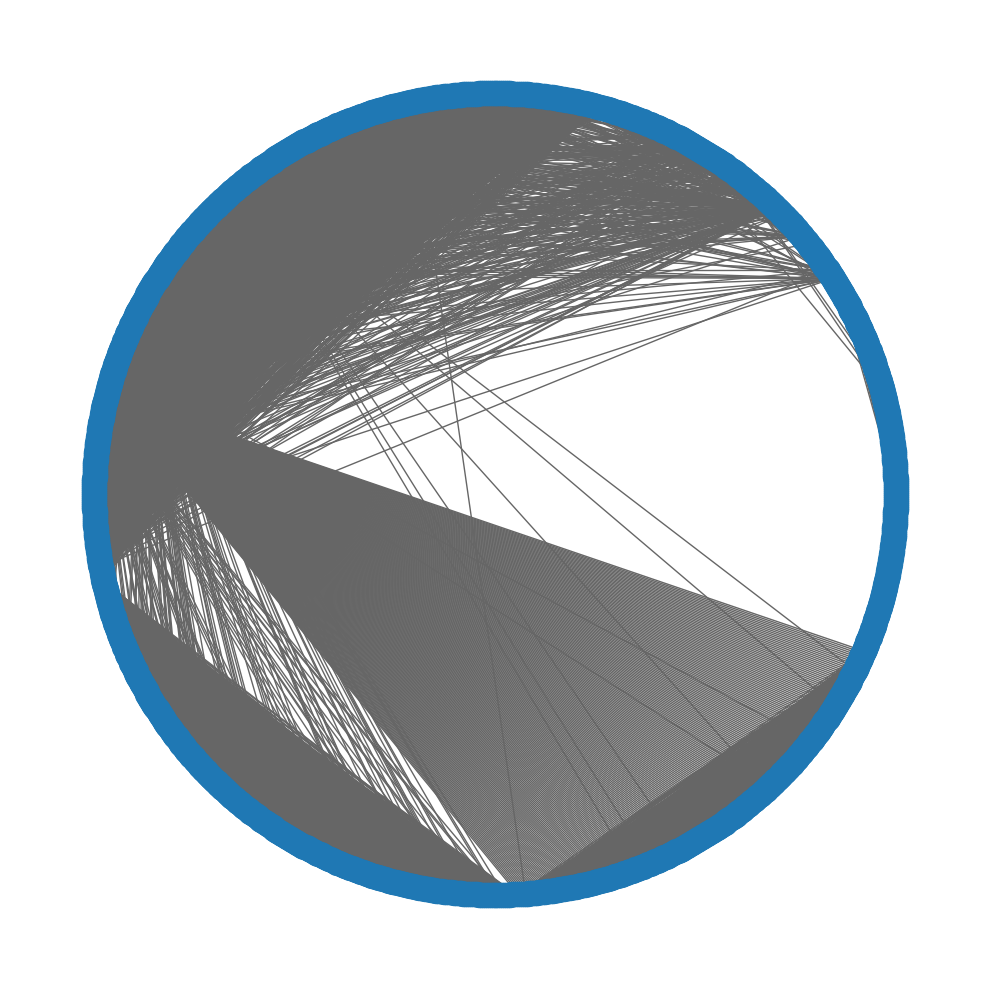

In [8]:
mpl.pyplot.figure(figsize=(10,10))
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, with_labels=False, edge_color='.4')
 
mpl.pyplot.axis('off')
mpl.pyplot.tight_layout();

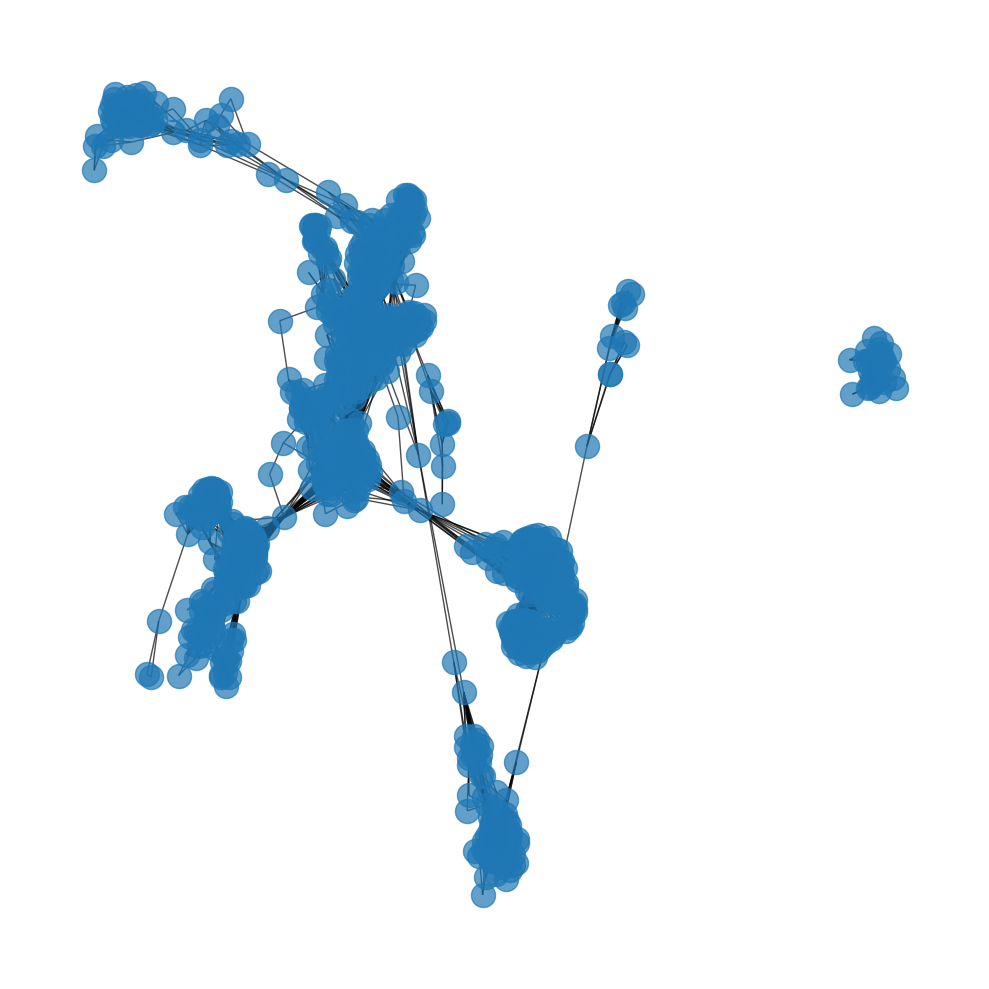

In [9]:
mpl.pyplot.figure(figsize=(10,10))
nx.draw_networkx(G, alpha=0.7, with_labels=False)
mpl.pyplot.axis('off')
mpl.pyplot.tight_layout();

In [10]:
#@title Creating Adjacency Matrix

l = list(G.nodes())
adj_G = nx.to_numpy_array(G, nodelist = l)
print(str(adj_G.shape)+'\n')
adj_G

(1295, 1295)



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
#@title Finding Non Existing Edge
# get all node pairs which don't have an edge
non_existing_edges = []
 
# traverse adjacency matrix
offset = 0
for i in range(adj_G.shape[0]):
   for j in range(offset,adj_G.shape[1]):
       if i != j:
           if adj_G[i,j] == 0:
                   non_existing_edges.extend([(l[i],l[j])])
 
   offset = offset + 1

print(non_existing_edges[:20])
print(len(non_existing_edges))

[(2, 3), (2, 7), (2, 10), (2, 13), (2, 16), (2, 17), (2, 23), (2, 24), (2, 25), (2, 29), (2, 40), (2, 45), (2, 48), (2, 55), (2, 56), (2, 57), (2, 59), (2, 62), (2, 64), (2, 65)]
819544


In [12]:
#@title Finding Connected Nodes
non_existing_edges_40000 = sorted(random.sample(non_existing_edges, k=40000))
non_existing_edges = [(i[0],i[1]) for i in non_existing_edges_40000 if nx.has_path(G, i[0], i[1])]

non_existing_edge_df = pd.DataFrame(data = non_existing_edges, columns =['Source', 'Destination'])
 
# create a column 'Connection' with default 0 (no-connection)
non_existing_edge_df['Connection'] = 0
 
non_existing_edge_df.head()

,Source,Destination,Connection
0,2,180,0
1,2,391,0
2,2,400,0
3,2,542,0
4,2,606,0


In [13]:
#@title Getting Removable Edges

def GettingRemoveableEdges(fb_graph):
    # Create a list of all indices of the node pairs in the fb dataframe,
    # which when removed won’t change the structure of our graph
    
    # create a copy
    fb_temp = fb_graph.copy()
    
    # for storing removable edges
    removable_edges_indices = []
    
    # number of connected components and nodes of G
    ncc = nx.number_connected_components(G)
    number_of_nodes = len(G.nodes)
    
    # for each node pair we will be removing a node pair and creating a new graph,
    # and check if the number of connected components and the number of nodes
    # are the same as the original graph
    for i in fb_graph.index.values:
    
        # remove a node pair and build a new graph
        G1 = nx.from_pandas_edgelist(fb_temp.drop(index= i), "Source", "Destination",
                                    create_using=nx.Graph())
    
        # If the number of connected components remain same as the original
        # graph we won't remove the edge
        if (nx.number_connected_components(G1) == ncc) and (len(G1.nodes) == number_of_nodes):
            removable_edges_indices.append(i)
    
            # drop the edge, so that for the next iteration the next G1
            # is created without this edge
            fb_temp = fb_temp.drop(index = i)

    print("before transform: ", removable_edges_indices)
    with open(os.path.join(PRJ_DIR,'removable_edges_indices.txt'), 'w') as f:
        removable_edges_indices = [str(elem.item()) for elem in removable_edges_indices]
        file_lines = "\n".join(removable_edges_indices)
        f.write(file_lines)

    return removable_edges_indices

if os.path.isfile(os.path.join(PRJ_DIR,'removable_edges_indices.txt')):
    print("Already have file!")
    with open(os.path.join(PRJ_DIR,'removable_edges_indices.txt'), 'r') as f:
        removable_edges_indices = f.readlines()
        removable_edges_indices = [int(elem) for elem in removable_edges_indices]
        print(removable_edges_indices)
else:
    removable_edges_indices = GettingRemoveableEdges(fb)

Already have file!
[0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 50, 52, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 218, 219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 232, 233, 234, 235, 236, 237, 238, 

In [14]:
#@title Creating Dataframe of Removable Edges

removeable_edge_df = fb.loc[removable_edges_indices]
removeable_edge_df['Connection'] = 1
 
removeable_edge_df.head()

,Source,Destination,Connection
0,2,116,1
1,2,226,1
3,3,25,1
4,3,67,1
5,3,142,1


In [15]:
#@title Creating Subgraph
non_existing_edge_df = non_existing_edge_df.append(removeable_edge_df[['Source', 'Destination', 'Connection']],
                ignore_index=True)

df3 = fb.drop(index=removeable_edge_df.index.values)

G_new = nx.from_pandas_edgelist(df3, "Source", "Destination",
                               create_using=nx.Graph())

print('Number of nodes', len(G_new.nodes))
print('Number of edges', len(G_new.edges))
print('Average degree', sum(dict(G_new.degree).values()) / len(G_new.nodes))

Number of nodes 1295
Number of edges 1292
Average degree 1.9953667953667953


<ipython-input-15-fe0337f77031>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_existing_edge_df = non_existing_edge_df.append(removeable_edge_df[['Source', 'Destination', 'Connection']],


In [16]:
%cd '/content/drive/MyDrive/Colab Notebooks/eliorc_node2vec/'
!pwd

/content/drive/MyDrive/Colab Notebooks/eliorc_node2vec
/content/drive/MyDrive/Colab Notebooks/eliorc_node2vec


In [17]:
#@title Generating Features of the Edges
from node2vec import Node2Vec
 
# Generating walks
node2vec = Node2Vec(G_new, dimensions=128, walk_length=16, num_walks=64)
 
# training the node2vec model
n2v_model = node2vec.fit(window=7, min_count=1)

edge_features = [
    (n2v_model.wv[str(i)]+n2v_model.wv[str(j)]) 
    for i,j in zip(non_existing_edge_df['Source'], non_existing_edge_df['Destination'])
]

Computing transition probabilities:   0%|          | 0/1295 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 64/64 [00:10<00:00,  6.31it/s]


In [19]:
#@title Applying Random algorithm Forest with GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score,confusion_matrix

X = np.array(edge_features)  
y = non_existing_edge_df['Connection']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

#classifier
random_forest_clf = RandomForestClassifier()
 
# parameters
param = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]}
 
# model
grid_random_forest_acc = GridSearchCV(random_forest_clf, param_grid = param)
 
# train the model
grid_random_forest_acc.fit(X_train, y_train)
 
print('Grid best parameter (max. accuracy): ', grid_random_forest_acc.best_params_)
print('Grid best score (accuracy): ', grid_random_forest_acc.best_score_)
 
# alternative metric to optimize over grid parameters: AUC
grid_random_forest_auc = GridSearchCV(random_forest_clf, param_grid = param, scoring = 'roc_auc')
grid_random_forest_auc.fit(X_train, y_train)
predict_proba = grid_random_forest_auc.predict_proba(X_test)[:,1]
 
print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
print('Grid best parameter (max. AUC): ', grid_random_forest_auc.best_params_)
print('Grid best score (AUC): ', grid_random_forest_auc.best_score_)

Grid best parameter (max. accuracy):  {'max_depth': 15, 'n_estimators': 100}
Grid best score (accuracy):  0.9151574840715911
Test set AUC:  0.9767631381852757
Grid best parameter (max. AUC):  {'max_depth': 15, 'n_estimators': 100}
Grid best score (AUC):  0.9761020949222307


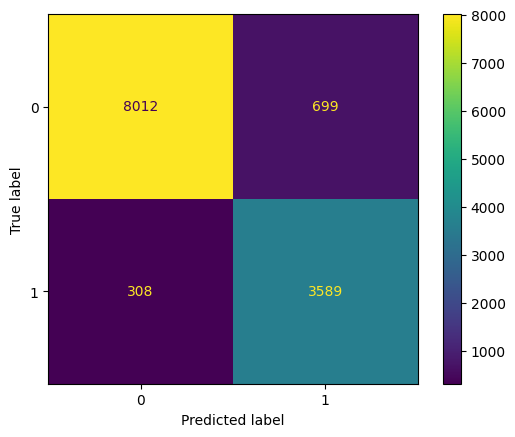

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

pred = grid_random_forest_auc.predict(X_test)
cm = confusion_matrix(pred,y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_random_forest_auc.classes_)
disp.plot()

Text(0, 0.5, 'True Positive Rate')

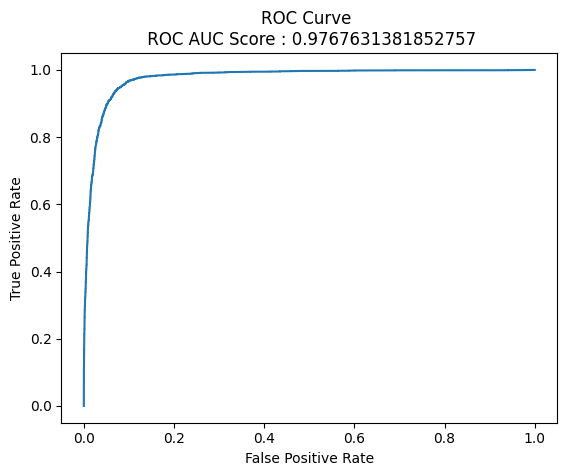

In [21]:
false_positive_rate,true_positive_rate,_ = roc_curve(y_test, predict_proba)
roc_auc_score = auc(false_positive_rate,true_positive_rate)

mpl.pyplot.plot(false_positive_rate,true_positive_rate)
mpl.pyplot.title(f'ROC Curve \n ROC AUC Score : {roc_auc_score}')
mpl.pyplot.xlabel('False Positive Rate')
mpl.pyplot.ylabel('True Positive Rate')